In [ ]:
import pandas as pd
import numpy as np
import random
import os
from rdkit.Chem import Draw,MACCSkeys
from rdkit import Chem,DataStructs

Code to get random different aromatic amine examples

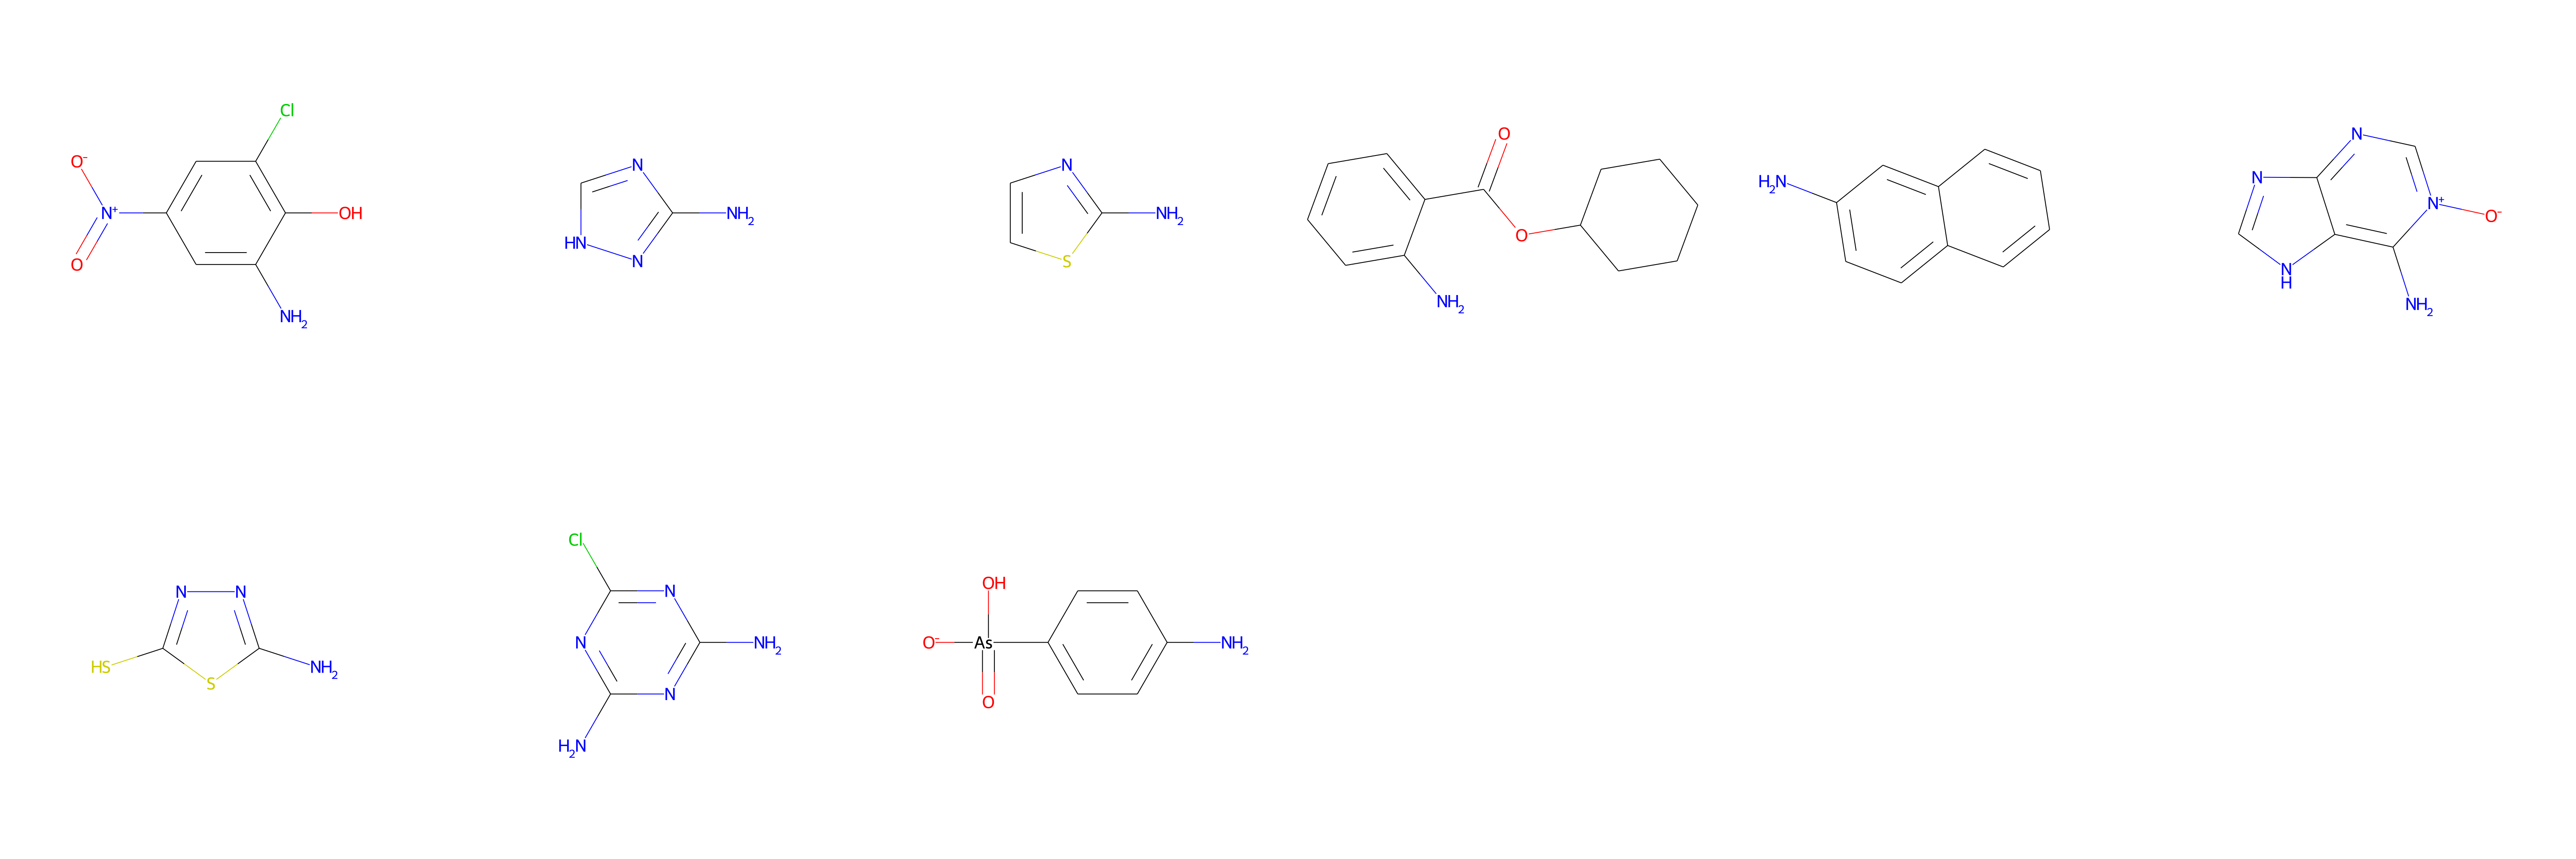

In [65]:
def most_diff(mols, n=10):
    fps = [Chem.RDKFingerprint(x) for x in mols]
    diff_mols = [mols[random.randrange(len(mols))]]
    while len(diff_mols) < n:
        tanis = [[DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(diff_mol),fp) for fp in fps] for diff_mol in diff_mols ]
        sum_tani = [sum(x) for x in zip(*tanis)]
        diff_index = min(range(len(sum_tani)), key=sum_tani.__getitem__)
        diff_mols += [mols[diff_index]]
    return diff_mols

aa = pd.read_csv('data/raw/selected_molecules.csv')
chosen_mols =most_diff(aa['smiles'].apply(lambda x: Chem.MolFromSmiles(x)),n=9)
Draw.MolsToGridImage(
    chosen_mols,
    molsPerRow=6, 
    subImgSize=[1000, 1000])

Code to get group of metabolites

In [171]:
def normalize_smiles(smi, InChi='NOT GIVEN'):      ## Converts each SMILES to an RDkit molecule then reconverts to SMILES. Ensures molecules with the same structure are the same SMILES
    try:
        smi_norm = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        return smi_norm
    except:
        try:
            smi_norm = Chem.MolToSmiles(Chem.MolFromInchi(InChi))
            return smi_norm
        except:
            return np.nan
def parent_finder(smi):         ## Searches the "smiles" column of the "data" dataframe of the original molecules and normalises both, returning a match if found
    for parent in data['smiles']:
        try:
            if Chem.MolToSmiles(Chem.MolFromSmiles(smi)) == Chem.MolToSmiles(Chem.MolFromSmiles(parent)):
                return parent
        except:
            continue
    return "No parent found"
def faster_parent_finder(smi):
    for parent in data['smiles']:
        try:
            if smi == parent:
                return parent
        except:
            continue
    return "No parent found" 
def drop_no_info_cols(df):
        res = df
        for col in df.columns:
                if len(df[col].unique()) == 1:
                        res = res.drop(col,axis=1)
                        print("dropped column:", col)
        return res
def try_find_padel(x):
    try:
        padel = list(padel_data[padel_data['smiles']==x].drop(['Name','smiles'],axis=1).iloc[0])
    except:
        padel = np.nan
    return padel
def get_ml_encoding(df, function=MACCSkeys.GenMACCSKeys):   ## returns a list, where each . Done to whole dataframe to allow for removing columns with NaN values
    def number_check(x):            ## Checks if a value can be converted to a float. Used to remove non-numeric encoding
        try:
            float(x)
            return x
        except:
            return "broken"

    ## Generate encoding list from smiles
    working_df = df.copy()      
    try:                     
        if function == 'PaDEL':
            working_df['encoding_list'] = working_df['smiles'].apply(lambda x: try_find_padel(x)) 
        elif function == 'Morgan':
            working_df['encoding_list'] = working_df['smiles'].apply(lambda x: list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2)))   
        else:
            working_df['encoding_list'] = working_df['smiles'].apply(lambda x: list(function(Chem.MolFromSmiles(x))))   
    except:
        return np.nan
    ## Create dataframe from encoding list
    saved_df =working_df
    # working_df = working_df.dropna(subset='encoding_list')                                    
    ## Transform encoding dataframe into a list of lists. Can be used to generate a new column of the original dataframe                            
    X = saved_df['encoding_list'].to_list()                                                                                                                
    return X
def bag_parent(smiles,met_df,function):
    ## Create dataframe from molecules with parent == smiles as well as the smiles molecule. Removes duplicates
    mol_family          =   met_df[met_df["parent smiles"]==smiles].append({'smiles':smiles},ignore_index=True).drop_duplicates(subset=["smiles"])
    ##  Encodes this family using above
    mol_family_encoded  =   get_ml_encoding(df = mol_family, function = function)
    return mol_family_encoded
def find_small_mol_family(df,parent_choice='smallest'):
    if parent_choice not in ['smallest','random']:
        print('Please use either "smallest" or "random" parent choice')
        return
    if parent_choice == 'smallest':
        ps = [Chem.MolFromSmiles(x) for x in df['parent smiles'].unique() if x != 'No parent found']
        parents = [Chem.MolToSmiles(p) for p in ps if p.GetNumAtoms() == min(p.GetNumAtoms() for p in ps)]
        parent = random.choice(parents)
    elif parent_choice == 'random':
        parent_index = random.randrange(len(df['parent smiles'].unique()))
        print(parent_index)
        parent = df['parent smiles'].unique()[parent_index]
    family = set(df[df['parent smiles'] == parent]['smiles'].to_list() + [parent])

    print('parent:',parent)
    return Draw.MolsToGridImage(
        [Chem.MolFromSmiles(x) for x in family],
        molsPerRow=6, 
        subImgSize=[1000, 1000])

parent: Nc1ncn[nH]1


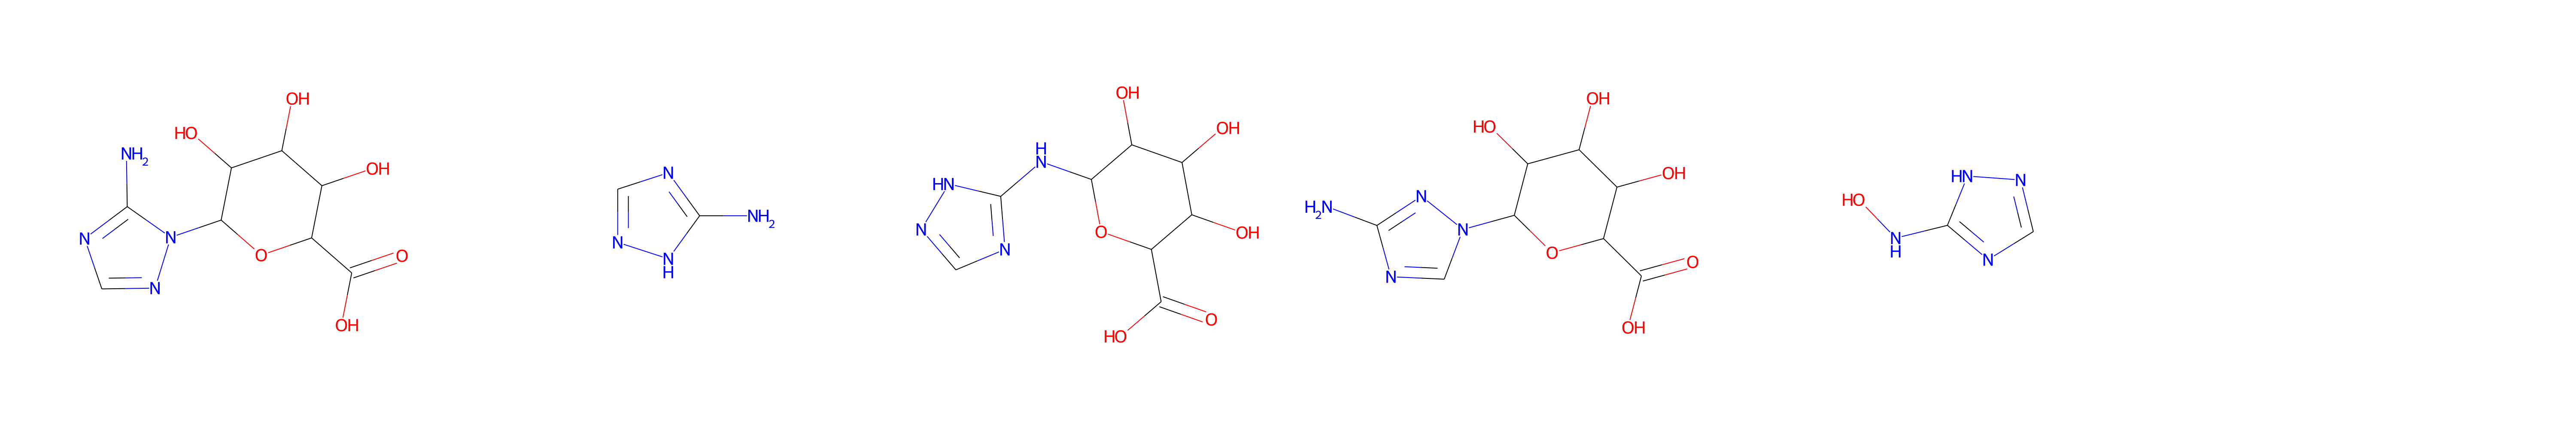

In [175]:
if not os.path.isfile("data/metabolite grouping/aa_metabolite_data.pk1"):
    ##          Step 1: Load data into dataframes
    data = pd.read_csv("data/raw/selected_molecules.csv")
    metabolite_data = pd.concat([pd.read_csv("data/raw/biotransformer_output_cyp1.csv"), pd.read_csv("data/raw/biotransformer_output_phaseII.csv")])

    ##          Step 2: Normailizing metabolite smiles and matching to parent (approx 220 secs) 
    metabolite_data['smiles']           = metabolite_data['SMILES'].apply(lambda x: normalize_smiles(x))
    metabolite_data['Precursor smiles']           = metabolite_data['Precursor SMILES'].apply(lambda x: normalize_smiles(x))
    metabolite_data                     = metabolite_data.dropna(axis=0,subset=['smiles']);   print("b")
    metabolite_data['parent smiles']    = metabolite_data['Precursor SMILES'].apply(lambda x:parent_finder(x));   print("c")
    metabolite_data.to_pickle("data/metabolite grouping/aa_metabolite_data.pk1")
else:
    metabolite_data = pd.read_pickle("data/metabolite grouping/aa_metabolite_data.pk1")

find_small_mol_family(df = metabolite_data)

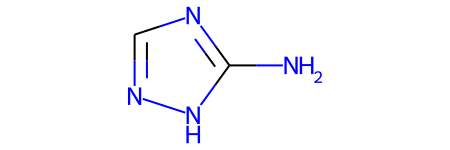

In [176]:
Chem.MolFromSmiles('Nc1ncn[nH]1')

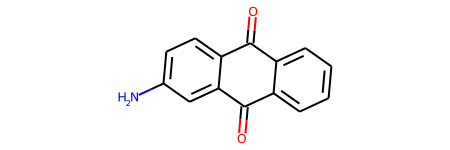

In [146]:
Chem.MolFromSmiles(parent)